### Local Setup

In [15]:
import gdown
VAR_ROOT = "vars/rnn"
gdown.download_folder("https://drive.google.com/drive/folders/1Giz6bK4qOkDyhDFIZbPjSjm6WeabK_5t?usp=sharing", output=VAR_ROOT, quiet=True)

['vars/rnn/lstm_history.pt', 'vars/rnn/lstm.pt']

### Google Colab Setup

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW3'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

Mounted at /content/drive
['data']


### Save/Load

In [12]:
import torch

def load(filename):
    return torch.load(VAR_ROOT + '/' + filename + '.pt', map_location=torch.device('cpu'))

def save(object, filename):
    filename = VAR_ROOT + '/' + filename + '.pt'
    if isinstance(object, torch.nn.Module):
        torch.save(object.state_dict(), filename)
    else:
        torch.save(object, filename)

## Imports

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [ ]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Files already exist, skipping download and extraction.
category = Italian - random name = Morra
category = Arabic - random name = Daher
category = Russian - random name = Balabukha
category = Polish - random name = Niemczyk
category = Czech - random name = Hlavsa
category = Russian - random name = Hanzhin
category = Russian - random name = Peller
category = Greek - random name = Karkampasis
category = English - random name = Rennalls
category = Scottish - random name = Johnston


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.concat([hidden, input], dim=1)
        hidden = F.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for letter in name_tensor:
        output, hidden = rnn(letter, hidden)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.4299 Mendes is predicted as a "Greek" name, status = ✗ (Portuguese)
10000 10% 1.9610 Wallace is predicted as a "French" name, status = ✗ (Scottish)
15000 15% 3.1416 St martin is predicted as a "Russian" name, status = ✗ (French)
20000 20% 0.0883 Christakos is predicted as a "Greek" name, status = ✓
25000 25% 0.3046 Chou is predicted as a "Korean" name, status = ✓
30000 30% 4.1247 Gerges is predicted as a "Portuguese" name, status = ✗ (Arabic)
35000 35% 0.0323 Giannakopoulos is predicted as a "Greek" name, status = ✓
40000 40% 0.8678 Enik is predicted as a "Russian" name, status = ✓
45000 45% 1.7940 Paternoster is predicted as a "Dutch" name, status = ✗ (German)
50000 50% 0.5786 Ichisada is predicted as a "Japanese" name, status = ✓
55000 55% 0.9800 Peusen is predicted as a "Dutch" name, status = ✓
60000 60% 0.4869 Qiu is predicted as a "Chinese" name, status = ✓
65000 65% 0.7358 Ustohal is predicted as a "Czech" name, status = ✓
70000 70% 1.1016 Bach is predicted as a "Vietna

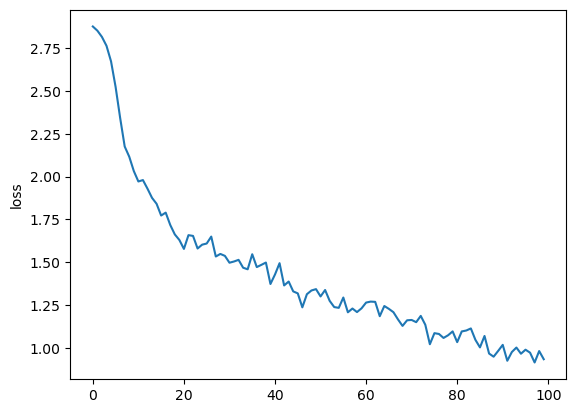

In [ ]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.ylabel('loss')
plt.show()

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

No. Because the network has an $O(T)$ serial part, where $T$ is the maximum length of sequences

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 0.9331
Epoch [20/100], Loss: 0.8528
Epoch [30/100], Loss: 0.7763
Epoch [40/100], Loss: 0.6876
Epoch [50/100], Loss: 0.5807
Epoch [60/100], Loss: 0.4564
Epoch [70/100], Loss: 0.3261
Epoch [80/100], Loss: 0.2131
Epoch [90/100], Loss: 0.1362
Epoch [100/100], Loss: 0.0964


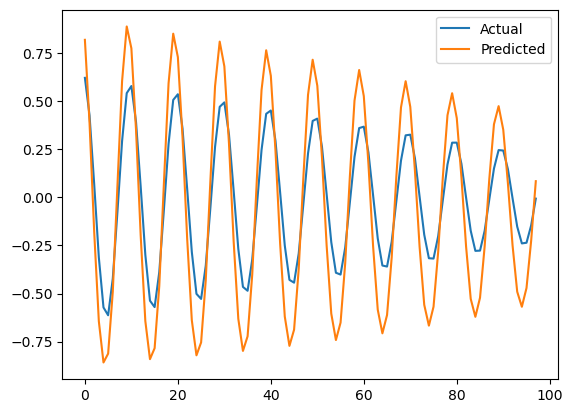

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [ ]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 3000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.W = nn.Linear(input_size + hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        """
        Inputs:
              input: (batch_size, input_size)
              hx: (batch_size, hidden_size)
        Outputs:
              hy: (batch_size, hidden_size)
              cy: (batch_size, hidden_size)
        """

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx
        input = torch.concat([input, hx], dim=1)
        gates = self.W(input)
        input_gate, forget_gate, cell_gate, output_gate = gates.split(self.hidden_size, dim=1)

        i_t = F.sigmoid(input_gate)
        f_t = F.sigmoid(forget_gate)
        g_t = F.tanh(cell_gate)
        o_t = F.sigmoid(output_gate)

        cy = f_t * cx + i_t * g_t
        hy = o_t * F.tanh(cy)

        return (hy, cy)

## LSTM Models

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn, cn))

        out = self.fc(hn)
        return out

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch, labels in train_loader:
        optimizer.zero_grad()
        output = model(batch.view(batch.shape[0], *batch.shape[2:]))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            output = model(batch.view(batch.shape[0], *batch.shape[2:]))
            _, predicted = output.max(1)
            correct +=  predicted.eq(labels).sum().item()
            total += labels.size(0)
            accuracy = correct / total
        print(f"Epoch({epoch + 1}/{num_epochs}); test_accuracy:{accuracy};")

Epoch(1/6); test_accuracy:0.9602;
Epoch(2/6); test_accuracy:0.9739;
Epoch(3/6); test_accuracy:0.9773;
Epoch(4/6); test_accuracy:0.9783;
Epoch(5/6); test_accuracy:0.9847;
Epoch(6/6); test_accuracy:0.9861;


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [3]:
import torch
CUDA = 'cuda'
device = CUDA if torch.cuda.is_available() else 'cpu'
device

'cpu'



### Data cleaning
Remove HTML tags, punctuation, numbers, stop words and convert into lowercase.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

In [39]:
import torch.utils.data

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = X
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

class TextDataset:
    def __init__(self) -> None:
        self.X, self.y  = self.__load_dataset()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.max_length = max([len(x) for x in self.X])

        self.dictionary = {}
        self.num_words = None
        self.__create_dict()
        self.X_train_indices = torch.stack([self.__get_indices(x) for x in self.X_train])
        self.X_test_indices = torch.stack([self.__get_indices(x) for x in self.X_test])


    def get_data(self):
        return TorchDataset(self.X_train_indices, self.y_train), TorchDataset(self.X_test_indices, self.y_test)

    def __load_dataset(self):
        nltk.download('stopwords', quiet=True)
        english_stops = stopwords.words('english')

        df = pd.read_csv('data/IMDB/IMDB Dataset.csv')
        X = df['review']
        y = df['sentiment']

        X = X.replace({'<.*?>': ''}, regex = True)          # remove html tag
        X = X.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
        X = X.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
        X = X.apply(lambda review: [w.lower() for w in review])   # lower case

        y = y.replace('positive', 1)
        y = y.replace('negative', 0)

        return X.values, y.values

    def __create_dict(self):
        self.num_words = 1
        for x in self.X_train:
            for word in x:
                if word not in self.dictionary:
                    self.dictionary[word] = self.num_words
                    self.num_words += 1

    def __get_indices(self, x):
        indices = torch.zeros(self.max_length, dtype=torch.int32)
        offset = self.max_length - len(x)
        for i, word in enumerate(x):
            indices[i + offset] =  self.dictionary.get(word, 0)

        return indices

In [40]:
dataset = TextDataset()
train_dataset, test_dataset = dataset.get_data()


In [ ]:
import torch.utils.data
from torch.utils.data import random_split

test_size = len(test_dataset) // 2
val_size = len(test_dataset) - test_size
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

### Creating the model

In [26]:
from torch import nn
class SentimentLSTM(nn.Module):
    def __init__(self, num_words, embedding_dim, hidden_size, num_classes=2) -> None:
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, hx=None):
        if hx == None:
            hn = torch.zeros(1, x.shape[0], self.hidden_size, dtype=torch.float32, device=device)
            cn = torch.zeros(1, x.shape[0], self.hidden_size, dtype=torch.float32, device=device)
            hx = (hn, cn)
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x, hx)
        out = self.dropout(hn.view(*hn.shape[1:]))
        out = self.fc(out)

        return out, (hn, cn)

In [33]:
model = SentimentLSTM(num_words=dataset.num_words, embedding_dim=64, hidden_size=256).to(device)

### Training the model

In [34]:
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

if device == CUDA:
    for epoch in range(num_epochs):
        corrects, total, total_loss = 0, 0, 0

        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            model.train()

            optimizer.zero_grad()
            output, _ = model(batch)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            corrects += predicted.eq(labels).sum().item()
            total += len(labels)
            total_loss += loss

        accuracy = corrects / total

        history['train_loss'].append(total_loss / total)
        history['train_acc'].append(accuracy)


        with torch.no_grad():
            corrects, total, total_loss = 0, 0, 0
            model.eval()
            for batch, labels in val_loader:
                batch, labels = batch.to(device), labels.to(device)
                output, _ = model(batch)
                total_loss += criterion(output, labels)

                _, predicted = output.max(1)
                corrects += predicted.eq(labels).sum().item()
                total += len(labels)

            accuracy = corrects / total

            history['val_loss'].append(total_loss / total)
            history['val_acc'].append(accuracy)

        print(f"Epoch({epoch+1}/{num_epochs})", end=' ')
        for key, value in history.items():
            print(f"{key}: {value[-1]};", end=' ')
        print()

    save(model, 'lstm')
    save(history, 'lstm_history')
else:
    model.load_state_dict(load('lstm'))
    history = load('lstm_history')


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

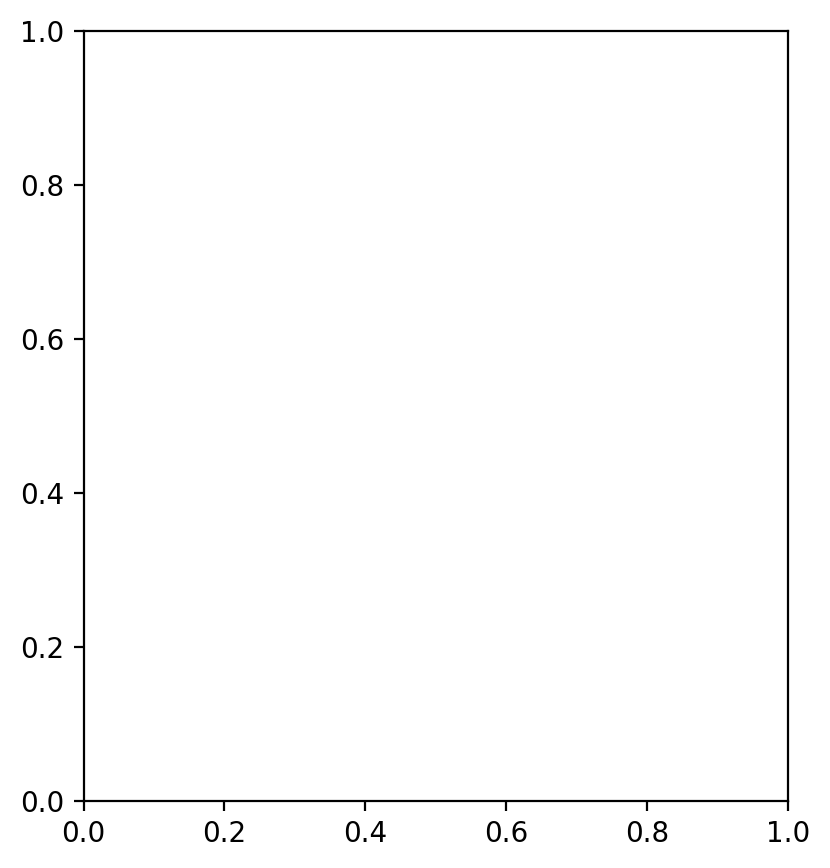

In [53]:
import matplotlib.pyplot as plt 
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

### Testing the model

In [49]:
correct = 0
for batch, labels in test_loader:
    output, _ = model(batch)
    _, predicted = output.max(1)
    correct += predicted.eq(labels).sum().item()
print("test_acc:", correct / len(test_dataset))

test_acc: 0.2537
